In [1]:
%matplotlib widget

import ipywidgets as widgets
from ipywidgets import HBox, VBox, jslink, Box, Layout
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display, Latex, Markdown, Image, Math
from scipy.integrate import solve_ivp
from scipy.signal import place_poles
import control.matlab as control

In [2]:
def make_box_layout():
     return widgets.Layout(
        border='solid 1px black',
        margin='0px 5px 5px 0px',
        padding='2px 2px 2px 2px'
     )

## LQ-Zustandsregler

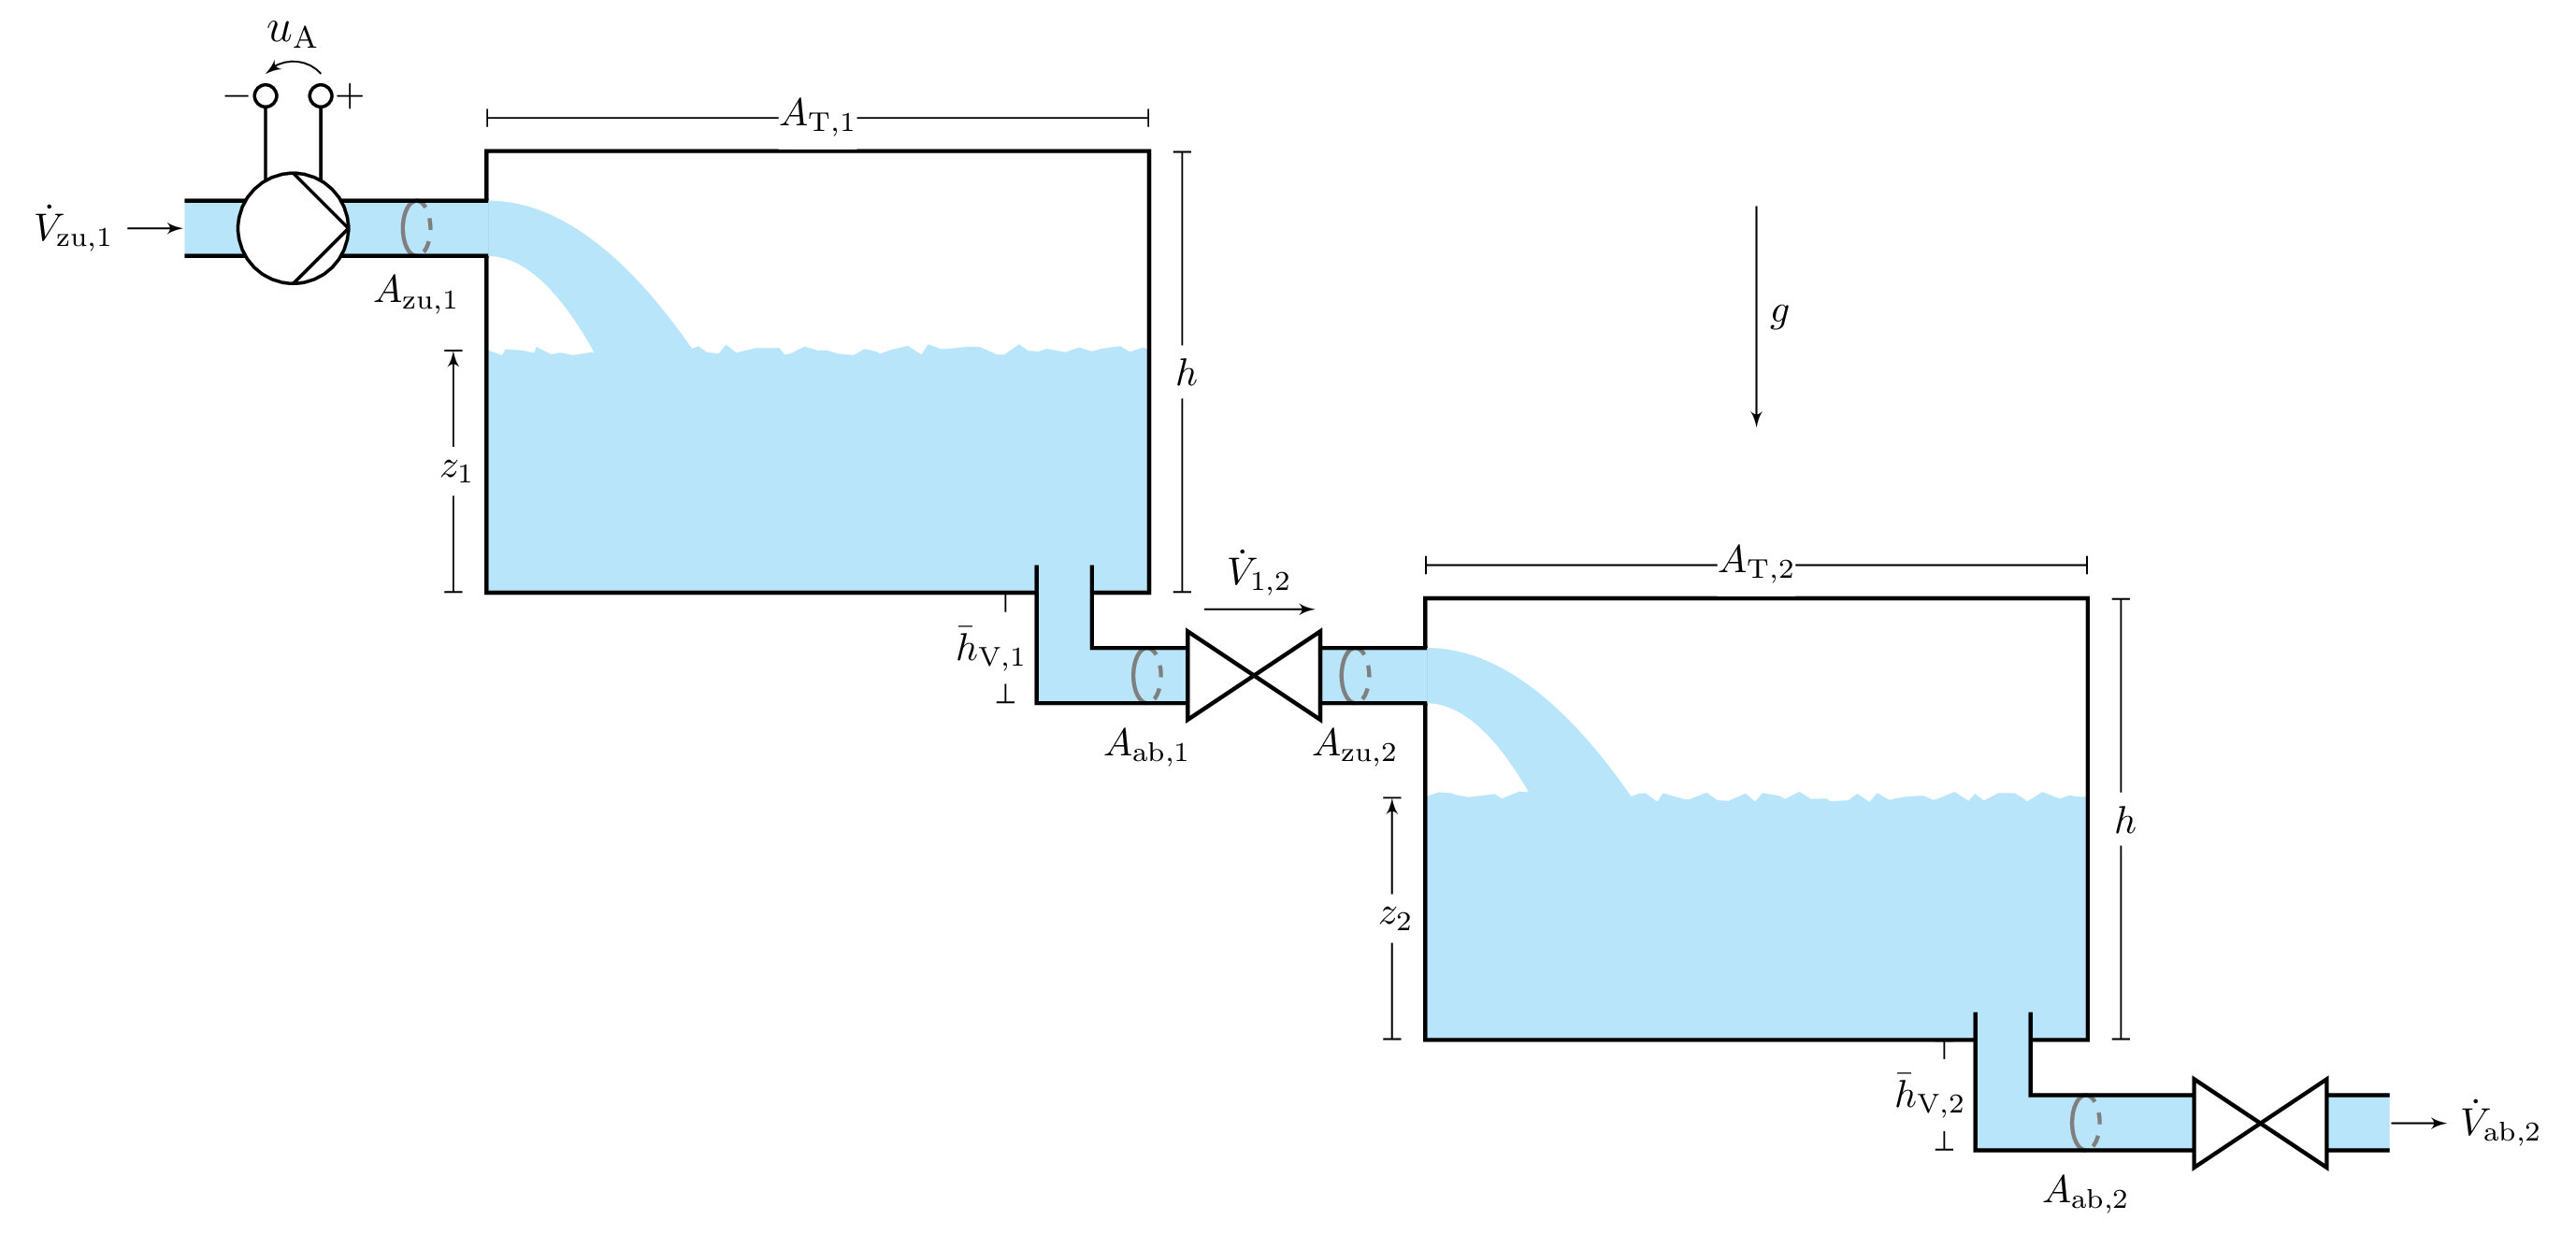

In [3]:
imag = Image("../../images/zweitank.png", width=800)
display(imag)

## 2-Tanksystem

- lineares Modell in der Form
    \begin{align*}
        \dot{\tilde{z}}_1(t) & = a_{11} \tilde{z}_1(t) + b \tilde{u}_{\text{A}}(t)\\
        \dot{\tilde{z}}_2(t) & = a_{21} \tilde{z}_1(t) + a_{22} \tilde{z}_2(t) 
    \end{align*}
    mit Ausgang $y(t) = z_2(t)$
- Zustandsdarstellung
    \begin{align*}
        \dot{\mathbf{z}}(t) & = \begin{pmatrix} a_{11} & 0 \\ a_{21} & a_{22} \end{pmatrix} \mathbf{z}(t) + \begin{pmatrix} b\\0 \end{pmatrix} u(t) \\
        y(t) & = \begin{pmatrix} 0 & 1 \end{pmatrix} \mathbf{z}(t)
    \end{align*}
    mit Zustand $\mathbf{z} = \begin{pmatrix} \tilde{z}_1 & \tilde{z}_2 \end{pmatrix}^{\intercal}$ und Eingang $u = \tilde{u}_{\text{A}}(t)$

__Definition Parammeter__

In [4]:
tSim = np.linspace(0, 300, 301)

In [5]:
x0 = [0.2, 0.15]
A = np.array([[-0.0289, 0], [0.0289, -0.0146]])
b = np.array([[0.0021], [0]])
c = np.array([[0], [1]])

## Steuerbarkeit

In [6]:
S = np.hstack((b, A.dot(b)))
display(Latex("$\\mathrm{{rang}}\\mathcal{{S}} = \\mathrm{{rang}}{} = {}$".format(sp.latex(sp.Matrix(S)), sp.latex(np.linalg.matrix_rank(S)))))

<IPython.core.display.Latex object>

## Systemeigenwerte

In [7]:
eigA = np.linalg.eig(A)[0]
Math(r's_1 = ' + str(eigA[0]) + r',~s_2 = ' + str(eigA[1]))

<IPython.core.display.Math object>

## Reglerentwurf

In [8]:
Q = np.diag([7.5, 50])
R = np.array([0.05])

In [16]:
k, P, EigCL = control.lqr(A, b, Q, R)
k = np.array(k)
Math(r'\boldsymbol{k}=' + sp.latex(sp.Matrix(k)) + r' \quad ' 
      + r'\boldsymbol{P}='+ sp.latex(sp.Matrix(P)) + r' \quad ' 
      + r'\boldsymbol{\lambda}=' + sp.latex(sp.Matrix(EigCL)))

<IPython.core.display.Math object>

## Simulation

In [10]:
def prozess(t, x, A, b, k):
    u = -k @ x
    dx = A @ x + b @ u

    return dx

In [11]:
def prozessVorfilter(t, x, yRef, A, b, c, k):
    V = 1 / (c.T @ np.linalg.inv(b @ k - A) @ b)
    u = V[0] * yRef - k @ x
    dx = A @ x + b @ u

    return dx

In [12]:
res = solve_ivp(prozess, [tSim[0], tSim[-1]], x0,
                t_eval=tSim, args=(A, b, k))

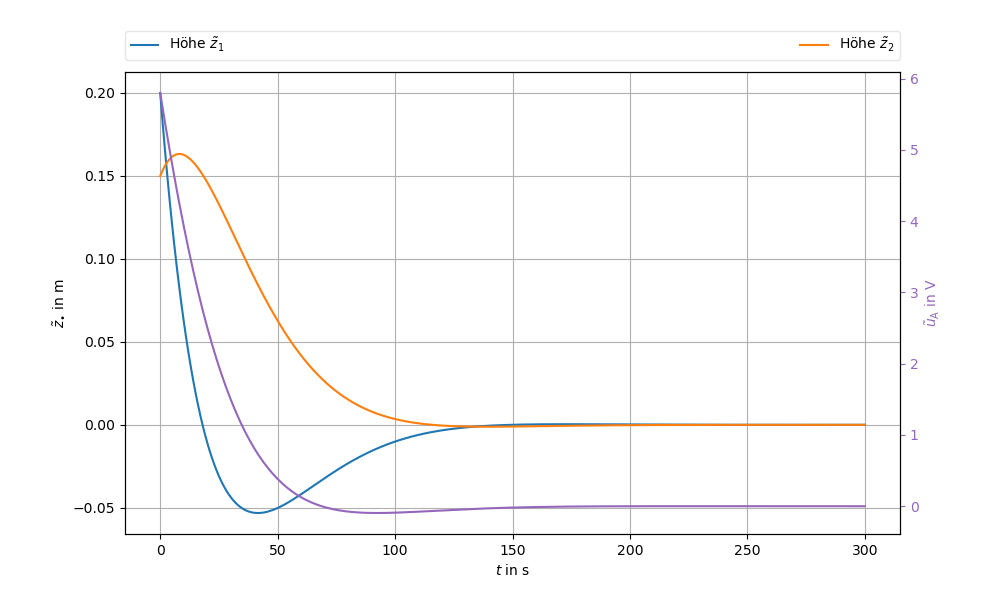

In [13]:
plt.close()

fig, axes10 = plt.subplots(1, 1, figsize=(10,6))
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

axes10.plot(res.t, res.y[0], label=r"Höhe $\tilde{z}_1$")
axes10.plot(res.t, res.y[1], label=r"Höhe $\tilde{z}_2$")

axes11 = axes10.twinx()
axes11.plot(res.t, (k @ res.y).T, 'C4')
axes11.set_ylabel(r"$\tilde{u}_{\mathrm{A}}$ in V", color='C4')
axes11.tick_params(axis='y', colors='C4')

axes10.set_xlabel(r"$t$ in s")
axes10.set_ylabel(r"$\tilde{z}_{\bullet}$ in m")

axes10.grid() 

handlesAx, labelsAx = axes10.get_legend_handles_labels()
fig.legend([handle for i, handle in enumerate(handlesAx)],
           [label for i, label in enumerate(labelsAx)],
           bbox_to_anchor=(0.125, 0.90, 0.775, .15), loc=3,
           ncol=2, mode="expand", borderaxespad=0., framealpha=0.5)
plt.show()

## Stabilisierung beliebiger Arbeitspunkte

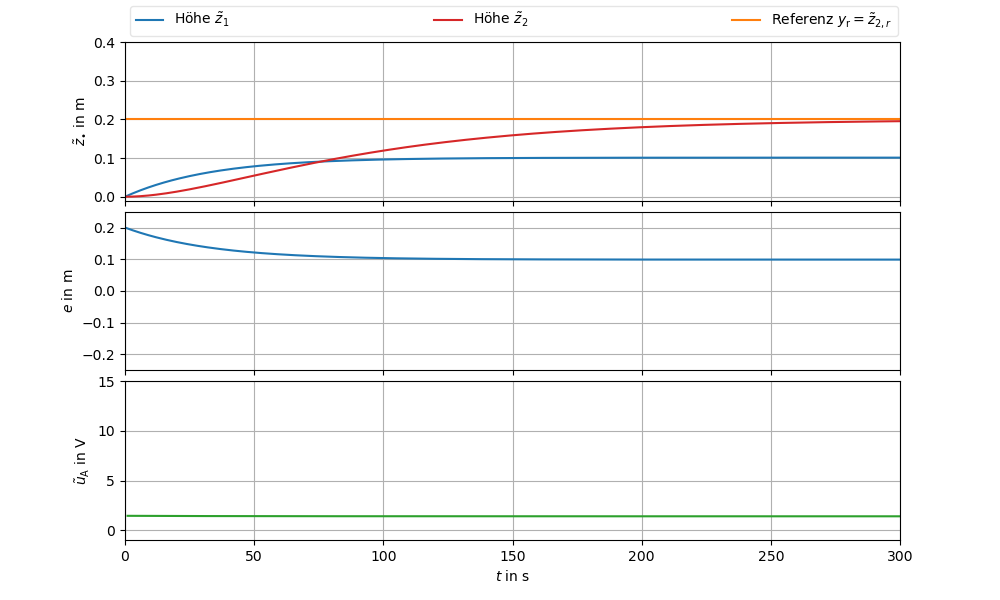

In [14]:
output = widgets.Output()

with output:
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 6), sharex=True, gridspec_kw={'height_ratios': [1, 1, 1]})

plt.subplots_adjust(wspace=0.2, hspace=0.07)
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.subplots_adjust(bottom=0.1, top=0.93, left=0.125, right=0.9)

ax1.set_xlim([0, tSim[-1]]) 
ax2.set_xlim([0, tSim[-1]])
ax3.set_xlim([0, tSim[-1]]) 
ax1.set_ylim([-0.01, 0.40]) 
ax2.set_ylim([-0.25, 0.25]) 
ax3.set_ylim([-1, 15]) 
ax1.grid()
ax2.grid()
ax3.grid()
ax1.set_ylabel(r"$\tilde{z}_{\bullet}$ in m")
ax2.set_ylabel(r"$e$ in m")
ax3.set_ylabel(r"$\tilde{u}_{\mathrm{A}}$ in V")
ax3.set_xlabel(r"$t$ in s")

ySys, = ax1.plot([], [], 'C0', label=r'Höhe $\tilde{z}_{1}$')
x2Sys, = ax1.plot([], [], 'C3', label=r'Höhe $\tilde{z}_{2}$')
yRefSys, = ax1.plot([], [], 'C1', label=r'Referenz $y_\mathrm{r} = \tilde{z}_{2,r}$')
eSys, = ax2.plot([], [], 'C0', label=r'Fehler $e$')
uFBSys, = ax3.plot([], [], 'C2', label=r'Regler $u$')

handlesAx, labelsAx = ax1.get_legend_handles_labels()

fig.legend([handle for i, handle in enumerate(handlesAx)],
           [label for i, label in enumerate(labelsAx)],
           bbox_to_anchor=(0.13, 0.94, 0.7675, .15), loc=3,
           ncol=3, mode="expand", borderaxespad=0., framealpha=0.5)

sliderYr = widgets.FloatSlider(value=0.2,
                               min=0,
                               max=0.3,
                               step=0.05,
                               description=r'$\tilde{z}_{2,\mathrm{r}}$')
sliderQ1 = widgets.FloatSlider(value=10,
                               min=1,
                               max=100,
                               step=1,
                               description=r'$q_{11}$')
sliderQ2 = widgets.FloatSlider(value=1,
                               min=1,
                               max=100,
                               step=1,
                               description=r'$q_{22}$')
sliderR = widgets.FloatSlider(value=1,
                               min=0.001,
                               max=1,
                               step=0.0005,
                               description=r'$R$')
sliderX01 = widgets.FloatSlider(value=0,
                                min=-0,
                                max=0.3,
                                step=0.05,
                                description=r'$\tilde{z}_1(0)$')
sliderX02 = widgets.FloatSlider(value=0,
                                min=0,
                                max=0.3,
                                step=0.05,
                                description=r'$\tilde{z}_2(0)$')

def calcSystem(_):
    yr = sliderYr.value
    
    Q = np.diag([sliderQ1.value, sliderQ2.value])
    R = np.array([sliderR.value])
    k, _, _  = control.lqr(A, b, Q, R)
    k = np.array(k)
    
    x0 = [sliderX01.value, sliderX02.value]
    res = solve_ivp(prozessVorfilter,
                    [tSim[0], tSim[-1]],
                    x0,
                    t_eval=tSim, args=(yr, A, b, c, k))
    
    V = 1 / (c.T @ np.linalg.inv(b @ k - A) @ b)
           
    sigFB = [V * yr - k @ res.y.T[idx + 1, :] for idx, t in enumerate(tSim[1:])]
    sigE = yr - res.y.T[:, 0]
    uFBSys.set_data(tSim[1:], sigFB)
    ySys.set_data(tSim, res.y.T[:, 0])
    x2Sys.set_data(tSim, res.y.T[:, 1])
    yRefSys.set_data(tSim[[0, -1]], np.array([yr, yr]))
    eSys.set_data(tSim, sigE)
    
    fig.canvas.draw()

sliderYr.observe(calcSystem, names='value')
sliderQ1.observe(calcSystem, names='value')
sliderQ2.observe(calcSystem, names='value')
sliderR.observe(calcSystem, names='value')
sliderX01.observe(calcSystem, names='value')
sliderX02.observe(calcSystem, names='value')

calcSystem(_)

stateContControls = VBox([sliderYr, sliderQ1, sliderQ2, sliderR])
stateContControls.layout = make_box_layout()
sysControls = VBox([sliderX01, sliderX02])
sysControls.layout = make_box_layout()

controls = HBox([sysControls, stateContControls])
VBox([controls, output], layout=Layout(display='flex', flex_flow='row', justify_content='center', align_items='center'))